# umap_and_supervised_embeddings

## Exploring UMAP with supervised forest embeddings

In this Notebook, we will explore a cool new dimensionality reduction technique called [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap) and check its applicability for doing supervised clustering and embedding over the similarity space computed from the leaves of a random forest.

## Why is this relevant?

Clustering is one of the most important ML applications in industry. I've always been interested with the question of clustering in large feature spaces. Given thousands of variables, how I can guarantee that my clusters capture relevant structure for my problem at hand? A nice solution, which I already discussed [here](https://gdmarmerola.github.io/forest-embeddings/), is to first select the most important features using a random forest and then using the forest's structure to extract similarities between samples by looking at how many times they co-ocurred on the leaves of the forest. However, the solution is limited by the number of samples, as I used dense dissimilarity matrices (big memory overhead) for clustering and the expensive t-SNE (big CPU overhead) for visualizing the embedding. Let us try to use a faster algorithm, UMAP, that should allow us to scale beyond what is doable with t-SNE and try alternative clustering algorithms that can partner with approximate nearest neighbor algorithms to reduce memory overhead.

In [1]:
# magics to make plots inline
%matplotlib inline

# importing relevant libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from tqdm import tqdm
from umap import UMAP
from pynndescent import NNDescent
from fastcluster import single
from scipy.cluster.hierarchy import cut_tree, fcluster, dendrogram
from scipy.spatial.distance import squareform
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

# turning off automatic plot showing, and setting style
plt.style.use('bmh')

## Data

Let us generate synthetic data using `make_classification` from `sklearn` so we can qualitatively validate our results. We generate data with 500,000 instances and 200 dimensions, where we have only 5 informative features (the rest are noise). We choose `n_clusters_per_class=10` so we have 20 natural clusters for our algorithm to discover, as we only have two classes. We make the problem unbalanced and add noise using `weights` and `flip_y` and finally add a little bit more of separation between classes using `class_sep=3.5`. 

In [2]:
# let us generate some data with 10 clusters per class
X, y = make_classification(n_samples=500000, n_features=200, n_informative=5, 
                           n_redundant=0, n_clusters_per_class=10, weights=[0.80],
                           flip_y=0.05, class_sep=3.5, random_state=42)

We also normalize all the columns to eliminate any scaling difference between informative and non-informative variables.

In [3]:
# normalizing to eliminate scaling differences
X = pd.DataFrame(StandardScaler().fit_transform(X))

## First try with UMAP

Let us now try to visualize the data using UMAP. First, we run a unsupervised embedding, computing regular euclidean distances between instances:

In [4]:
# building supervised embedding with UMAP
%time unsup_embed = UMAP().fit_transform(X)

Wall time: 18min 17s


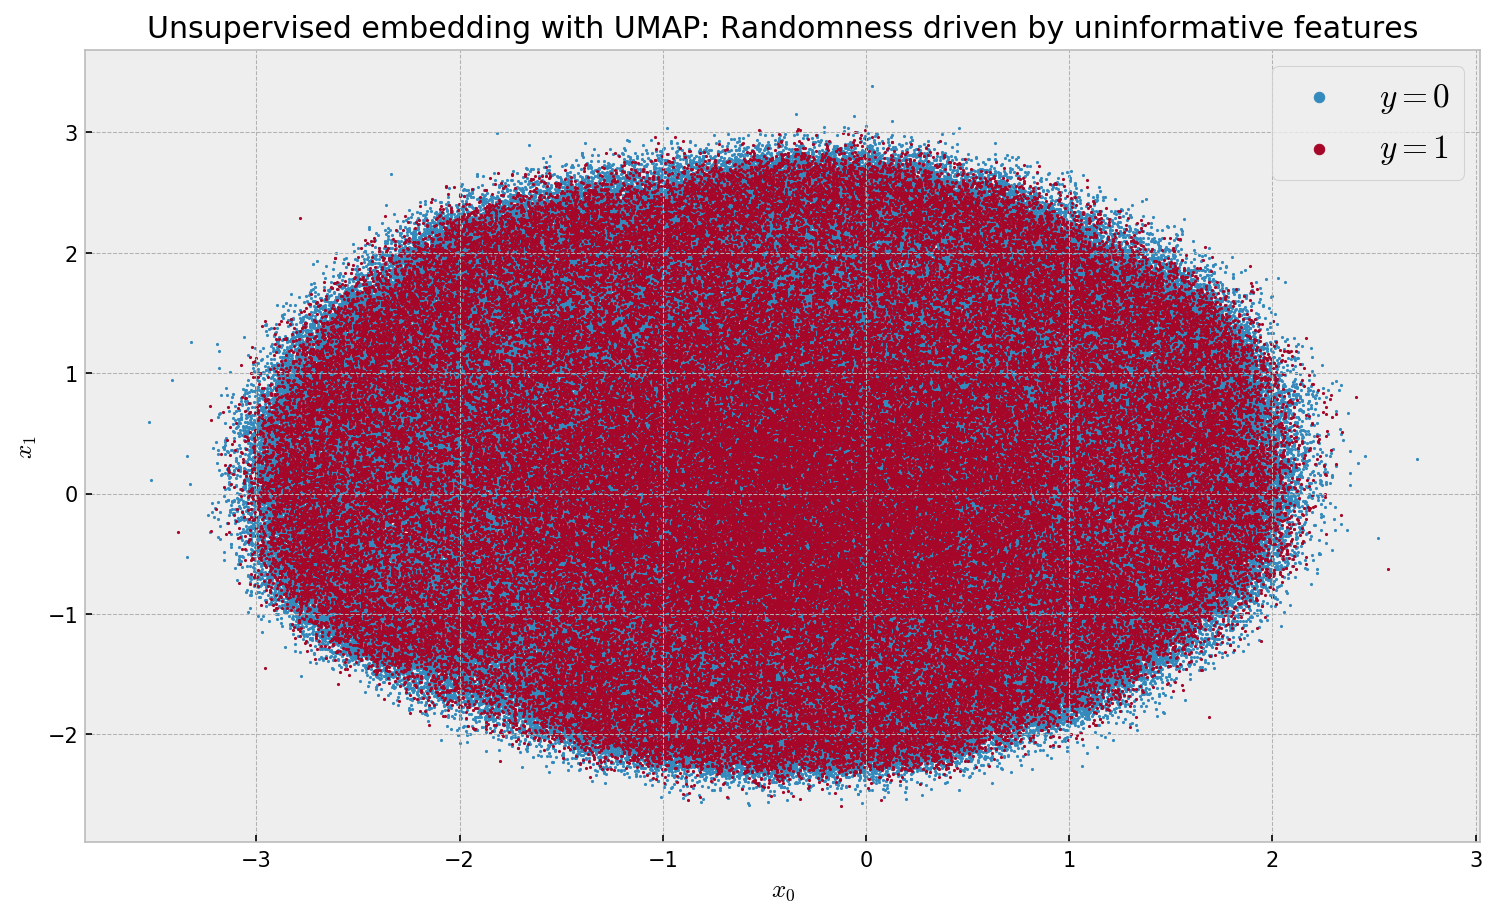

In [5]:
# plotting the unsup_embedding
plt.figure(figsize=(12,7), dpi=150)
plt.scatter(unsup_embed[y == 0,0], unsup_embed[y == 0,1], s=1, c='C0', cmap='viridis', label='$y=0$')
plt.scatter(unsup_embed[y == 1,0], unsup_embed[y == 1,1], s=1, c='C1', cmap='viridis', label='$y=1$')
plt.title('Unsupervised embedding with UMAP: Randomness driven by uninformative features')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')
plt.legend(fontsize=16, markerscale=5);

The algorithm is very fast at 18min 17s wall time. However, we observe a meaningless embedding, as the uninformative features overwhelm the informative ones when we compute euclidean distances. In order to improve this, we can try to use UMAP's feature to compute a supervised embedding:

In [6]:
# building supervised embedding with UMAP
%time sup_embed_umap = UMAP().fit_transform(X, y=y)

Wall time: 19min 2s


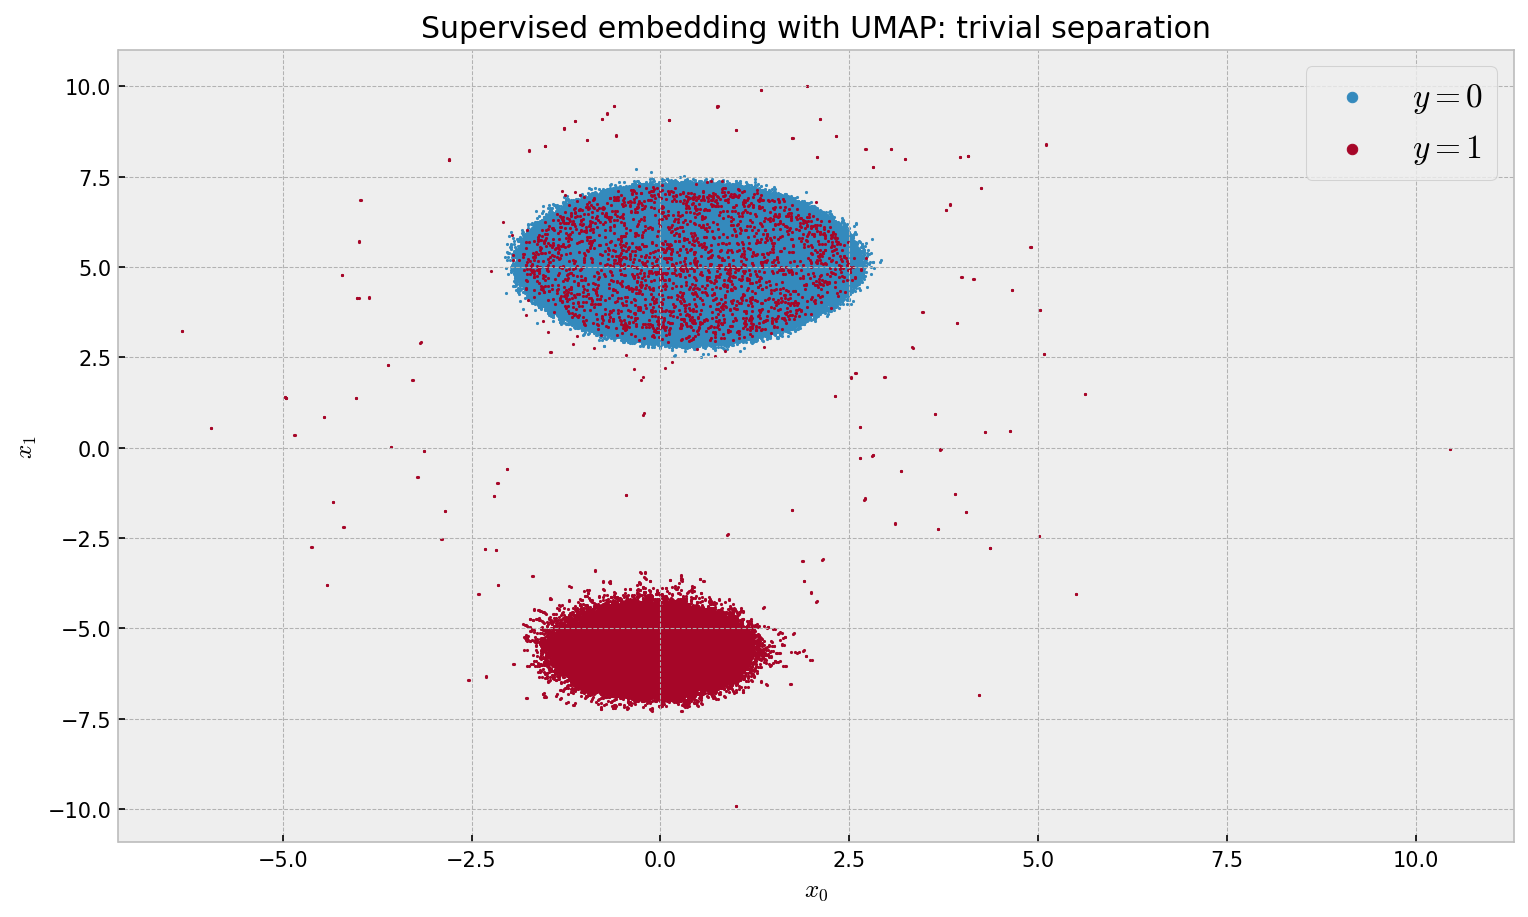

In [7]:
# plotting the embedding
plt.figure(figsize=(12,7), dpi=150)
plt.scatter(sup_embed_umap[y == 0,0], sup_embed_umap[y == 0,1], s=1, c='C0', cmap='viridis', label='$y=0$')
plt.scatter(sup_embed_umap[y == 1,0], sup_embed_umap[y == 1,1], s=1, c='C1', cmap='viridis', label='$y=1$')
plt.title('Supervised embedding with UMAP: trivial separation')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')
plt.legend(fontsize=16, markerscale=5);

The results are a little bit underwhelming, as we only observe 2 clusters (not the intended 20). Seems like UMAP just separated the classes not discarding the irrelevant features. The shape of the individual clusters resembles what we got in the unsupervised embedding. This calls for a better solution.

## Forest embeddings

As previously discussed [here](https://gdmarmerola.github.io/forest-embeddings/), forest embeddings present a nice solution for extracting relevant structure in messy and high-dimensional data. The intuition is simple: train a Random Forest (or better, Extremely Randomized Trees) to predict the target variable and extract similarities between samples by looking at how many times they co-ocurred on the leaves of the forest. Let us run this step-by-step:

### Model Validation

First, let us validate our model, an `ExtraTrees` from `sklearn`. We choose large `min_samples_leaf` to keep our trees from growing too much and our leaf-based similarity easy to compute. We use a cheap 2-fold cross validation, as we have a reasonable amount of data.

In [27]:
# model instance
et = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=500, 
                          max_features=0.80, bootstrap=True, class_weight='balanced', n_jobs=-1)

# validation instance
skf = StratifiedKFold(n_splits=2, shuffle=True)

# getting the model validation predictions
preds = cross_val_predict(et, X, y, cv=skf, method='predict_proba')

# evaluating the model
print('Area under the ROC Curve:', roc_auc_score(y, preds[:,1]))

Area under the ROC Curve: 0.9499562071682836


Cool. The model shows great performance at 0.9499 AUC. Now, we can move to computing the embedding. 

### Model application and embedding

As our model showed reasonable validation results, we can train and apply it on the whole dataset, keeping track of which leaves in the forest each sample was assigned to.

In [9]:
# let us train our model with the full data
et.fit(X, y)

# and get the leaves that each sample was assigned to
leaves = et.apply(X)
print(leaves)

[[764 699 813 ... 590 346 898]
 [227 163 290 ...  70  24 374]
 [867 915 482 ... 474 867 793]
 ...
 [118 186 258 ... 179 572 644]
 [710 928 437 ... 493 406 702]
 [263 105 289 ... 234 554  58]]


The numpy array contains the leaf indices that each sample was assigned to in the forest. For instance, the first sample was assigned to leaf 764 in the first tree, leaf 699 in the second tree and leaf 898 in the last tree.

Given the leaf assignments, we are now ready to use UMAP to calculate our low-dimensional embedding. We choose `metric='hamming'` so that our distance is proportional to how many times samples have **not** co-ocurred in the forest's leaves.

In [10]:
# calculating the embedding with hamming distance
%time sup_embed_et = UMAP(metric='hamming').fit_transform(leaves)

Wall time: 28min 46s


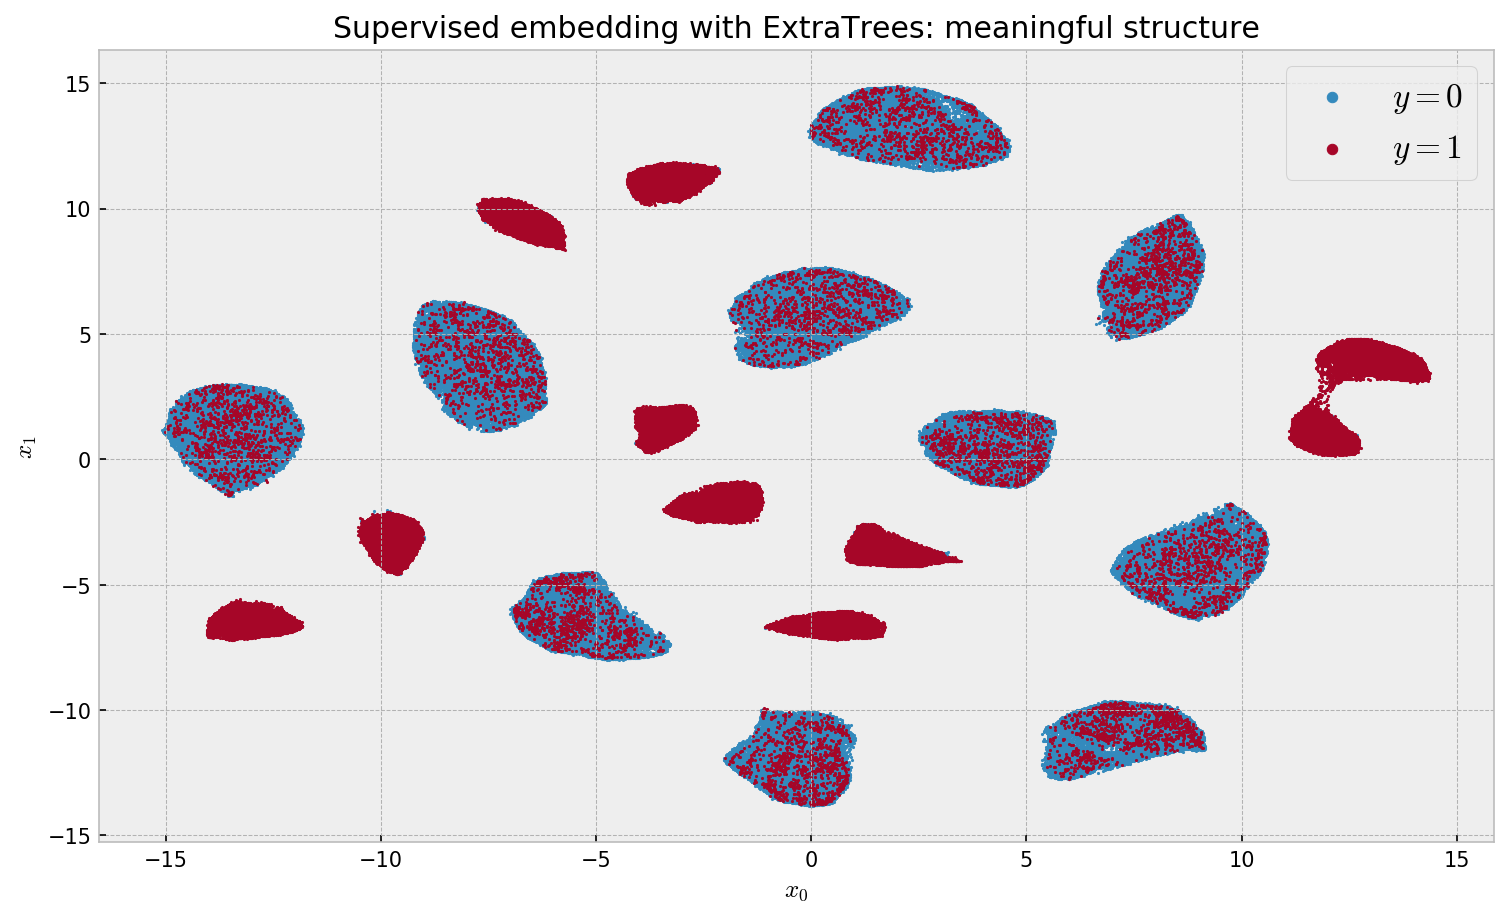

In [26]:
# plotting the embedding
plt.figure(figsize=(12,7), dpi=150)
plt.scatter(sup_embed_et[y == 0,0], sup_embed_et[y == 0,1], s=1, c='C0', cmap='viridis', label='$y=0$')
plt.scatter(sup_embed_et[y == 1,0], sup_embed_et[y == 1,1], s=1, c='C1', cmap='viridis', label='$y=1$')
plt.title('Supervised embedding with ExtraTrees: meaningful structure')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')
plt.legend(fontsize=16, markerscale=5);

Finally, we get meaningful results. We can see 20 clusters, as expected, with 10 clusters for each label. The algorithm is relatively fast considering our 500K dataset size, at 28min 46s wall time. Let us look at variable importance:

In [12]:
# building a dataframe to inspect variable importance
importances = pd.DataFrame({'importance':et.feature_importances_, 
                            'variable':range(len(et.feature_importances_))})

# showing importances in decresing order
importances.sort_values('importance', ascending=False).head(10)

,importance,variable
63,0.290723,63
187,0.220707,187
158,0.203393,158
176,0.145058,176
152,0.133577,152
40,0.000048,40
142,0.000044,142
177,0.000044,177
60,0.000043,60
43,0.000042,43


The algorithm correctly idenfied 5 important variables as well. This fact helps explain why we could recover meaningful structure: our leaf similarity measure effectively throws away distances on the irrelevant dimensions' axes.

So now that we have a reliable way of comparing samples, we can perform clustering! However, we have a problem: the scale of the data. Let us try to devise a way to make this viable.

## Clustering on the forest embedding

Given that we're using a non-eucliean distance metric, the first algorithm that comes to mind is hierarchical clustering. However, we need to provide it with the full distance matrix between all samples, which is very expensive to get. Let us try some clustering alternatives to solve this problem.

### Decision trees

Let us use a decision tree for clustering, which is a simplification of our forest. We just train a Decision Tree Classifier setting the maximum number of leaf nodes `max_leaf_nodes` equal to our number of intended clusters. 

In [13]:
# instance of our classifier
# max_leaf_nodes should be our number of clusters
dt = DecisionTreeClassifier(max_leaf_nodes=20)

In [14]:
# fitting and applying
dt.fit(X, y)
clusters = dt.apply(X)

Text(0,0.5,'$x_1$')

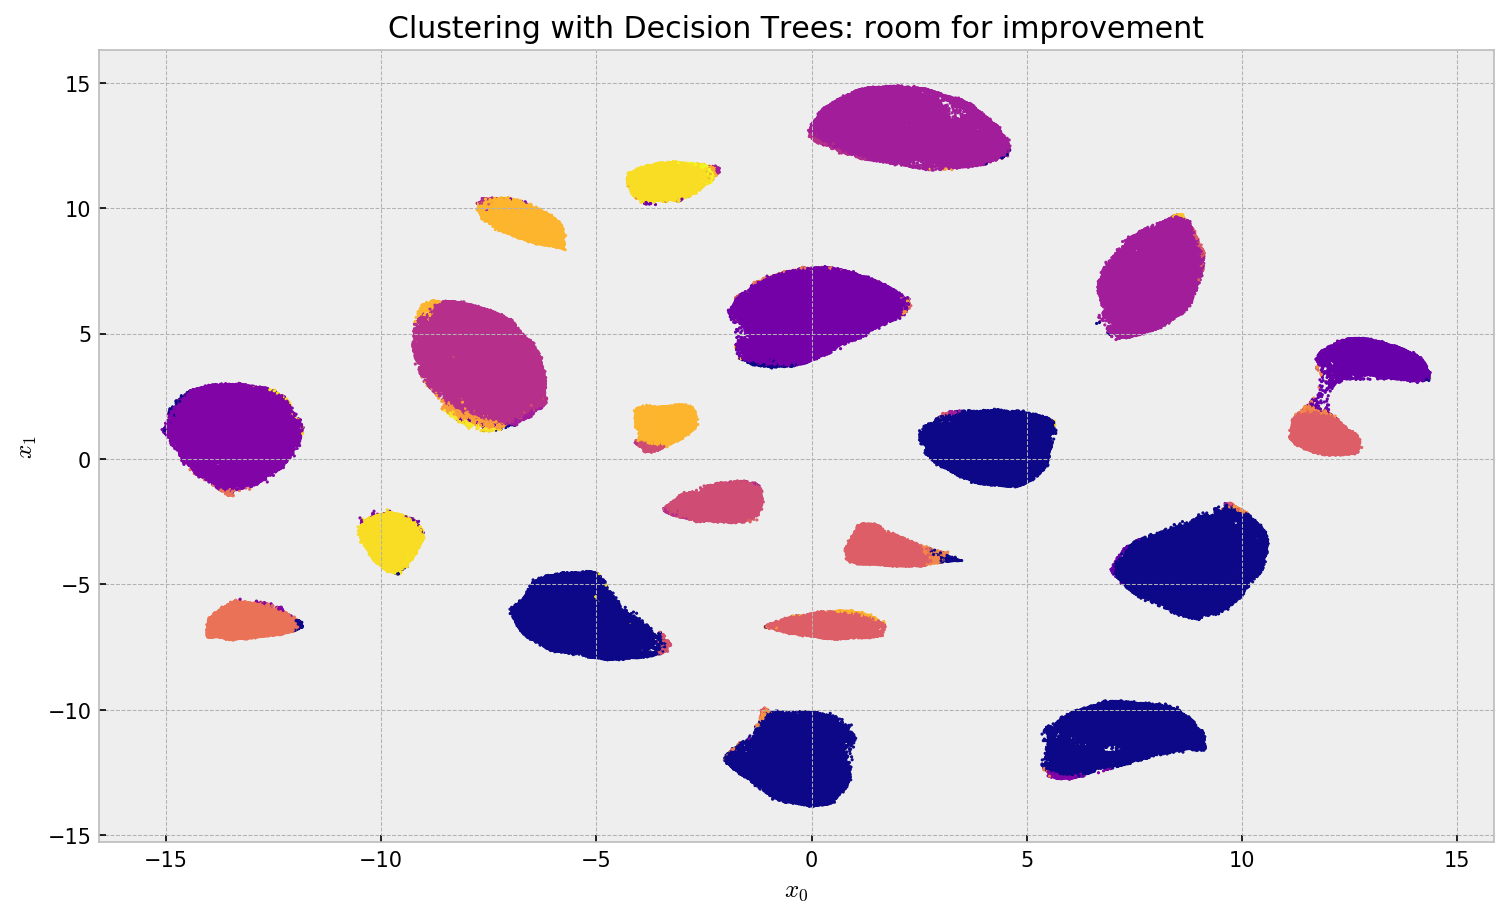

In [15]:
# plotting the embedding
plt.figure(figsize=(12,7), dpi=150)
plt.scatter(sup_embed_et[:,0], sup_embed_et[:,1], s=1, c=clusters, cmap='plasma')
plt.title('Clustering with Decision Trees: room for improvement')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')

Clustering using a Decision tree showed fair results, but with much room for improvement. The algorithm assigns the same label to different clusters, oversimplifying the structure. Also, it misses some of the assignments, especially on the large clusters. Let us try a promising alternative.

### Hierarchical Clustering

Let us experiment with hierarchical clustering now. We start by taking a sample of the embedding we have and runnning single-linkage clustering on it. This way, we save memory and time, at the cost of not clustering every instance in our data. 

In [17]:
# taking a sample of the dataframe
embed_sample = pd.DataFrame(sup_embed_et).sample(50000, random_state=42)

In [18]:
# running fastcluster hierarchical clustering on the improved embedding
%time H = single(embed_sample)

Wall time: 30.6 s


`fastcluster` does e very good job at 30.6s wall time. Then, we obtain a hard clustering by cutting the single-linkage tree at a point that gives us 20 clusters, and create a dataframe to store our instances and cluster assignments.

In [19]:
# getting the clusters
% time clusters = cut_tree(H, height=0.35)
print('Number of clusters:', len(np.unique(clusters)))

Wall time: 30.8 s
Number of clusters: 20


In [20]:
# creating a dataframe for the clustering sample
clust_sample_df = pd.DataFrame({'cluster': clusters.reshape(-1), 'cl_sample':range(len(clusters))})

Now, given our approximate clustering, we create an index using NN-Descent, and search for the 1-nearest neighbor for every instance in our data. This is very fast at around 18s.

In [21]:
# creating an index with the sample used for clustering
%time index = NNDescent(embed_sample, n_neighbors=10)

# querying for all the data
%time nn = index.query(clustering_embed_et, k=1)

Wall time: 7.94 s
Wall time: 9.34 s


Finally, we "predict" the clusters of all the instances by assigning to an unlabeled instance the cluster of its closest labeled instance. We do that just by merging pandas dataframes:

In [22]:
# creating a dataframe with nearest neighbors for all samples
to_cluster_df = pd.DataFrame({'sample':range(clustering_embed_et.shape[0]), 'cl_sample': nn[0].reshape(-1)})

In [23]:
# merging to assign cluster to all other samples, and tidying it
final_cluster_df = to_cluster_df.merge(clust_sample_df, on='cl_sample')
final_cluster_df = final_cluster_df.set_index('sample').sort_index()

Finally, we observe the clustering results:

Text(0,0.5,'$x_1$')

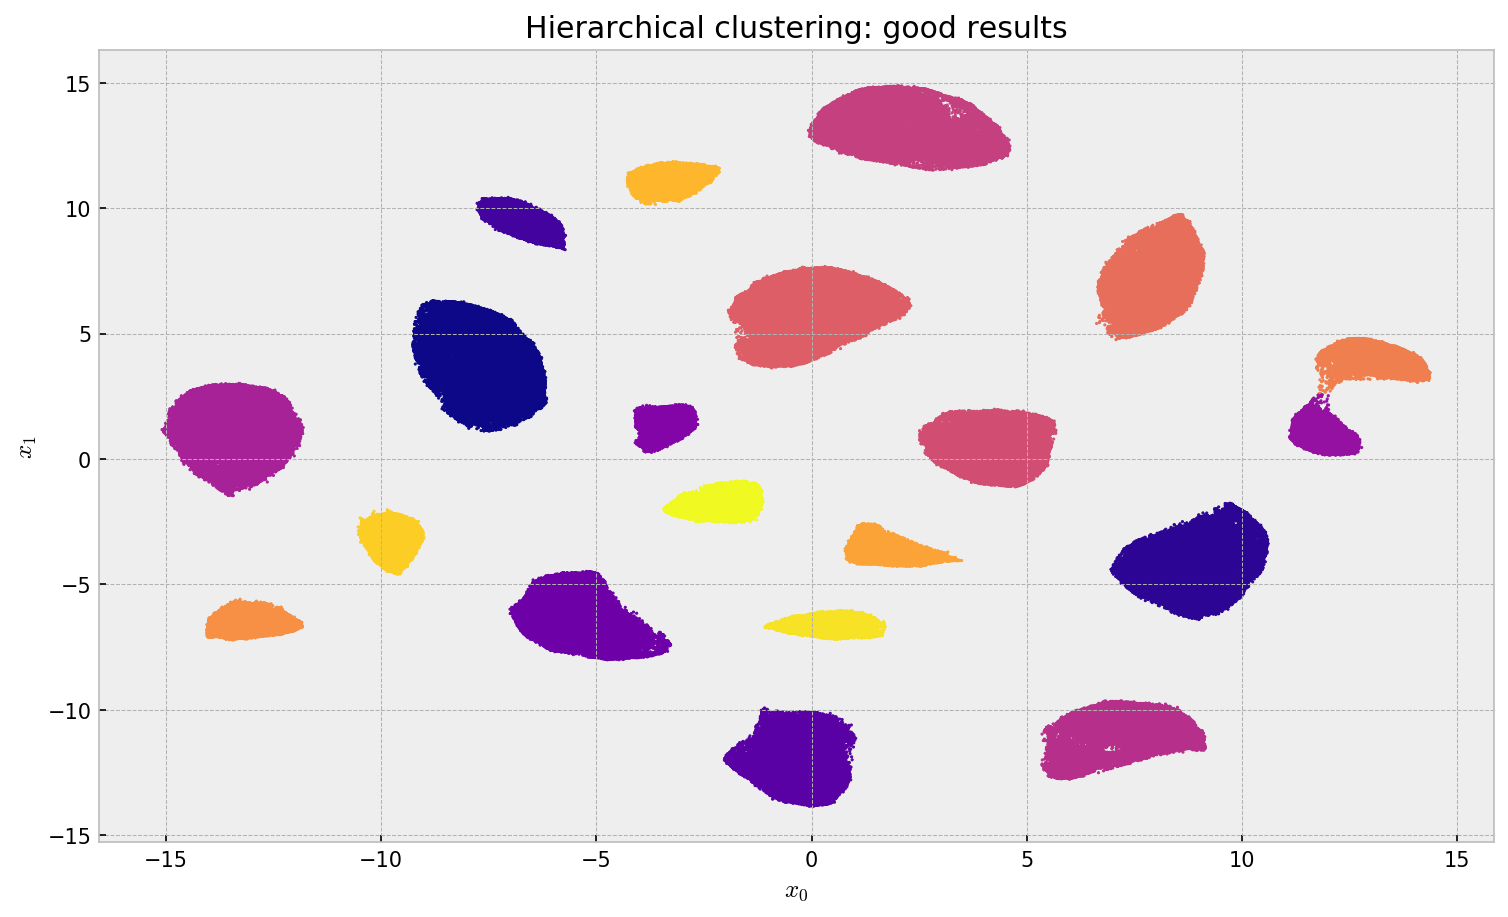

In [24]:
# plotting the embedding
plt.figure(figsize=(12,7), dpi=150)
plt.scatter(sup_embed_et[:,0], sup_embed_et[:,1], s=1, c=final_cluster_df['cluster'], cmap='plasma')
plt.title('Hierarchical clustering: good results')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')

The result looks very promising. There is much less confusion between clusters and the algorithm did not the same label to different clusters as before. The 1-NN approximation was reasonable: Qualitatively, we can see no points assigned to the wrong cluster.

At this point, we would be ready to qualitatively analyze the clusters we obtained: these could be clients that would click or not click on a ad, or maybe sales reps with better or worse performance.

## Conclusion

In this post, we explored a supervised dimensionality reduction technique which makes use of a convenient partnership: a supervised classification model with a unsupervised manifold learning model. For the classification model we use tree-based learning algorithms, as we can use leaf co-ocurrence to devise a similarity metric that captures only relevant structure (w.r.t to the classification problem) in the data. For the unsupervised manifold learning model, we choose UMAP, which improves upon t-SNE on speed, quality, and flexibility.

Given our embedding, we also explored clustering at scale using Decision Trees, which turn out to be an efficient but inaccurate approach, as it oversimplifies the structure in the data. Also, we used hierarchical clustering, which can be very expensive given 500,000 observations but was made practical by clustering on a sample then using NN-Descent to assign clusters to unlabeled instances.

I hope you liked this analysis! You can find the Jupyter Notebook [here]().